# Kalman Filter (Forced Oscillation with Decay)

Kalman Filter のパッケージとしては pykalman(https://pykalman.github.io) があるが，<br>
Nan や観測データよりも細かいステップでの予測分布の更新など柔軟に対応できるプログラムを自分で作りたいというモチベーション

Kalman Filter について知りたい人は，以下の文献を参考にしてほしい．
- 樋口知之編著，上野玄太・中野慎也・中村和幸・吉田亮著，データ同化入門ー次世代のシミュレーション技術ー，朝倉書店，2011．
- 淡路敏之・蒲地政文・池田元美・石川洋一，データ同化ー観測・実験とモデルを融合するイノベーションー，京都大学学術出版会，2009．

## -----------コードを書く前の下準備----------

### Forced Oscillation with Decay (減衰項付き強制振動)

今回は，淡路他著の5.2節にある減衰項付き強制振動問題を考える．質点$m$の減衰項付き強制振動の支配方程式は以下である．
$$
\begin{align*}
&\frac{dx}{dt}=v\\
&m\frac{dv}{dt}=-kx-rv+w
\end{align*}
$$

ここで，$x$は質点の位置，$v$は速度，$k$は振動定数，$r$は減衰定数，$w$は強制力である．オイラーの前進差分を適用すると，次のように表せる．
$$
\begin{align*}
&x_{t+1}=x_t+\Delta tv_{t-1}\\
&v_{t+1}=-k\frac{\Delta t}{m}x_t+\left(1-r\frac{\Delta t}{m}\right)v_t+\frac{\Delta t}{m}w_t
\end{align*}
$$

今回，パラメータは既知のものとして，$m=1.0, k=0.5, r=0.75, \Delta t=1.0$として双子実験を行う．

### Twin Experiment (双子実験)

双子実験とは
- 決定論的シミュレーション+ノイズによって観測値を生成し，その観測値を用いてデータ同化をしたとき，どれぐらいフィットしているか確認する手法．
- 津波や地震等，特定の地点における観測を得たいと考えても，得られないケースが多いので，双子実験がよく用いられる．
- Lorenz63 model, Lorenz 96 model 等カオス系非線形方程式で試しにやってみることも多い

今回は，真値（完全シミュレーション），シミュレーション値(シミュレーションで使うパラメータ),観測値を次のようにセットアップする．
- 真値：$x_0=5.0, v_0=0.0, w_t=\sin(2\pi t/10)$
- シミュレーション値 : $x_0=6.0, v_0=0.0, w_t=\sin(2\pi t/10)+q,\ q\sim N(0,0.5^2)$
- 観測値 : $y_t=x_t^{true}+\varepsilon,\ \varepsilon\sim N(0, 1)$

### Linear Gauss State Space Model（線形・ガウス状態空間モデル）

一般に，カルマンフィルタでは，線形・ガウス状態空間モデルを考える．これは，次の様に表せる．
$$
\begin{align}
&x_{t+1} = F_tx_t + b + N(0,Q_t)\\
&y_t = H_tx_t + d + N(0,R_t)
\end{align}
$$
ここで，$x_t$は時刻$t$における状態変数，$y_t$は時刻$t$における観測変数，$F_t$はシステム行列，$Q_t$はシステムノイズの共分散行列，$H_t$は観測行列，$R_t$は観測ノイズの共分散行列，$b,d$は各モデルのオフセット（切片）を表す．

今回の場合は，外力(強制力)を考えて，
$$
\begin{align}
&x_{t+1} = F_tx_t + \Gamma_tw_t + G_tN(0,Q_t)\\
&y_t = H_tx_t + N(0,R_t)
\end{align}
$$
となるが，システムノイズは強制力によってのみ生ずると仮定しているので，
$$
\begin{align}
&x_{t+1} = F_tx_t + G_tw_t + G_tN(0,Q_t)\\
&y_t = H_tx_t + N(0,R_t)
\end{align}
$$
と問題を考えれば良いことになる．

状態ベクトル$\mathbf{x}_t=(x_t, v_t)^T$，観測ベクトル$\mathbf{y}_t=(y_t)$とすれば，状態遷移行列$F$，外力行列$G$，観測行列$H$は以下のようになる．
$$F=\left(\begin{array}{cc}1&\Delta t\\-k\Delta t/m&1-r\Delta t/m\end{array}\right),\ G=\left(\begin{array}{c}0\\\Delta t/m\end{array}\right),\ H=\left(\begin{array}{cc}1&0\end{array}\right)$$

初期予測分布の分散共分散行列$V_{0|0}$，システムノイズ共分散行列$Q$，観測ノイズ共分散行列$R$は，以下のようになる．
$$V_{0|0}=\left(\begin{array}{cc}1&0\\0&0\end{array}\right),\ Q=(0.5^2),\ R=(1)$$
ここで，$R$は観測値生成時の情報を用いて構成しているので，一般にはこんな簡単にセットアップしてはいけないことに注意したい．

### Kalman Filter Algorithm

カルマンフィルターのアルゴリズムは，以下であった．
1. 初期状態のフィルタ分布の平均 $x_{0|0}$，共分散行列$V_{0|0}$を与える
1. $t=1$から$T$まで次の予測ステップ・フィルタステップを繰り返す

予測ステップ
$$
\begin{gather}
x_{t|t-1}=F_tx_{t-1|t-1}\\
V_{t|t-1}=F_tV_{t-1|t-1}F_t^T+G_tQ_tG_t
\end{gather}
$$

フィルタステップ
$$
\begin{gather}
K_t = V_{t|t-1}H_t^T (H_tV_{t|t-1}H_t^T+R_t)^{-1}\\
x_{t|t} = x_{t|t-1}+K_t(y_t-H_tx_{t|t-1})\\
V_{t|t} = V_{t|t-1} - K_t H_t V_{t|t-1}
\end{gather}
$$

### RTS Smoothing Algorithm

カルマンフィルタによって，$x_{T|T},V_{T|T}$が得られたら，$t=T-1,\cdots,0$に対して，
$$
\begin{align*}
&A_t=V_{t|t}F_{t+1}^TV_{t+1|t}^{-1}\\
&x_{t|T} = x_{t|t} + A_t(x_{t+1|T} - x_{t+1|t})\\
&V_{t|T} = V_{t|t} + A_t(V_{t+1|T} - V_{t+1|t})A_t^T
\end{align*}
$$
によって固定区間平滑化分布の平均$x_{t|T}$と共分散行列$V_{t|T}$がわかる．ここで，$A_t$は固定区間平滑化ゲインと呼ばれている．

### Estimation of Forcing by RTS Smoother

RTSスムーザーによる外力推定は，以下の式で表せる．
$$
\begin{align*}
&T_t=Q_tG_t^TV_{t+1|t}^{-1}\\
&q_{t|T}=q_t+T_t(x_{t+1|T}-x_{t+1|t})\\
&Q_{t|T}=Q_t+T_t(V_{t+1|T}-V_{t+1|t})T_t^T
\end{align*}
$$
ここで，$T_t$は制御問題に対するスムーザーゲイン行列と呼ばれている．

## ----------コード作成----------

ディレクトリ構造について
- DataAssimilation > try_and_error > Python_source : saving place for source
- DataAssimilation > try_and_error > plot : saving place for plot result

バージョンについて
- Mac OS 10.10
- Jupyter 4.3.0
- Python 3.6.1
- numpy 1.12.1
- pandas 0.20.1
- matplotlib 2.0.2
- seaborn 0.7.1
- scikit_learn 0.18.1

In [95]:
# install packages
import math
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE

### 真値，観測値生成用関数

In [137]:
# Euler forward differential
def Euler_forward_differential (state, m, w, k, r, dt, t) :
    '''
    <Input Variables>
    state [n_dim] {float} : position and velocity (x, v) (位置と速度)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    t {int} : time (ステップ番号)
    
    <Variables>
    x {float} : position (位置)
    v {float} : velocity (速度)
    '''
    x = state[0]
    v = state[1]

    state[0] = x + dt * v
    state[1] = v + dt / m * (- k * x - r * v + w(t * dt))
    return state

# perfect simulation
def perfect_simulation (initial_state, m, w, k, r, dt, T) :
    '''
    <Input Variables>
    initial_state [n_dim] {float} : initial state (x0, v0) (初期状態変数)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    T {float} : end time (最終時間)
    
    <Variables in this function>
    L {int} : length of time (ステップ数)
    x {float} : position (位置)
    v {float} : velocity (速度)
    w_perf {float} : perfect forcing (外力)
    state [n_dim] {float} : position and velocity (updated) (状態)
    '''
    L = math.ceil(T / dt) + 1
    x = np.zeros(L + 1)
    v = np.zeros(L + 1)
    w_perf = np.zeros(L + 1)
    state = initial_state
    x[0] = state[0]
    v[0] = state[1]
    w_perf[0] = w(0)
    for t in range(L) :
        state = Euler_forward_differential(state, m, w, k, r, dt, t)
        x[t + 1] = state[0]
        v[t + 1] = state[1]
        w_perf[t + 1] = w((t + 1) * dt)
    return x, v, w_perf

# observation (perfect simulation + noise)
def make_observation (initial_state, m, w, k, r, dt, T, noise_sd) :
    '''
    <Input Variables>
    initial_state [n_dim] {float} : initial state (x0, v0) (初期状態変数)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    T {float} : end time (最終時間)
    noise_sd {float} : standard deviation of Nomal noise (観測ノイズの標準偏差)
    
    <Variables in this function>
    L {int} : length of time (ステップ数)
    x {float} : position (位置)
    v {float} : velocity (速度)
    w_obs {float} : forcing (観測外力)
    state [n_dim] {float} : position and velocity (updated) (状態)
    noise [n_dim] {float} : normal noise ~ N(0, noise_sd**2) (観測ノイズ)
    '''
    L = math.ceil(T / dt) + 1
    x = np.zeros(L + 1)
    v = np.zeros(L + 1)
    w_obs = np.zeros(L + 1)
    state = initial_state
    x[0] = state[0]
    v[0] = state[1]
    w_obs[0] = w(0)
    for t in range(L) :
        if t%2 == 0 :
            noise = rd.normal(0, noise_sd, size = 1)
        else :
            noise = 0
        w_obs[t + 1] = w((t + 1) * dt) + noise
        state = Euler_forward_differential(state, m, w, k, r, dt, t) + np.array([dt / m * noise, 0])
        x[t + 1] = state[0]
        v[t + 1] = state[1]
    return x, v, w_obs

# simulation (perfect simulation + noise)
def make_simulation (initial_state, m, w, k, r, dt, T, noise_sd) :
    '''
    <Input Variables>
    initial_state [n_dim] {float} : initial state (x0, v0) (初期状態変数)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    T {float} : end time (最終時間)
    noise_sd {float} : standard deviation of Nomal noise (観測ノイズの標準偏差)
    
    <Variables in this function>
    L {int} : length of time (ステップ数)
    x {float} : position (位置)
    v {float} : velocity (速度)
    w_obs {float} : forcing (観測外力)
    state [n_dim] {float} : position and velocity (updated) (状態)
    noise [n_dim] {float} : normal noise ~ N(0, noise_sd**2) (観測ノイズ)
    '''
    L = math.ceil(T / dt) + 1
    x = np.zeros(L + 1)
    v = np.zeros(L + 1)
    w_obs = np.zeros(L + 1)
    state = initial_state
    x[0] = state[0]
    v[0] = state[1]
    w_obs[0] = w(0)
    for t in range(L) :
        if t%2 == 0 :
            noise = rd.normal(0, noise_sd, size = 1)
        w_obs[t + 1] = w((t + 1) * dt) + noise
        state = Euler_forward_differential(state, m, w, k, r, dt, t) + np.array([dt / m * noise, 0])
        x[t + 1] = state[0]
        v[t + 1] = state[1]
    return x, v, w_obs

### カルマンフィルターのクラス作成

In [149]:
class Kalman_Filter(object) :
    '''
    all numpy variable (numpy 変数で定義したものを入れる)
    コード上では，pred, filt が0:Tであり，tはtに対応している
    一方，smooth は 0:T-1であり，tはt-1に対応している
    
    <Input Variables>
    observation [time, n_dim_obs] {float} : observation y （観測値）
    initial_mean [time, n_dim_sys] {float} : initial state mean (初期フィルタ分布の平均)
    initial_covariance [n_dim_sys, n_dim_sys] {float} : initial state covariance （初期フィルタ分布の共分散行列）
    transition_matrix [n_dim_sys, n_dim_sys] {float} : transition matrix from x_{t-1} to x_t （システムモデルの変換行列）
    transition_noise_matrix [n_dim_noise, n_dim_sys] {float} : transition noise matrix (外力行列，ノイズ変換行列)
    observation_matrix [n_dim_sys, n_dim_obs] {float} : observation matrix （観測行列）
    transition_covariance [n_dim_sys, n_dim_sys] {float} : covariance of system noise （システムノイズの共分散行列）
    observation_covariance [n_dim_obs, n_dim_obs] {float} : covariance of observation noise （観測ノイズの共分散行列）
    transition_offsets [n_dim_sys] {float} : offsets of system transition model （システムモデルの切片 ＝ バイアス = オフセット）
    observation_offsets [n_dim_obs] {float} : offsets of observation model （観測モデルの切片 = バイアス = オフセット）
    n_dim_sys {int} : dimension of system variable （システム変数の次元）
    n_dim_obs {int} : dimension of observation variable （観測変数の次元）
    
    <Variables>
    y [time, n_dim_obs] {float} : observation y （観測値）
    F [n_dim_sys, n_dim_sys] {float} : transition matrix from x_{t-1} to x_t （システムモデルの変換行列）
    G [n_dim_noise, n_dim_sys] {float} : transition noise matrix (外力行列，ノイズ変換行列)
    Q [n_dim_sys, n_dim_sys] {float} : covariance of system noise （システムノイズの共分散行列）
    b [time, n_dim_sys] {float} : offsets of system transition model （システムモデルの切片 ＝ バイアス = オフセット）
    H [n_dim_sys, n_dim_obs] {float} : observation matrix （観測行列）
    R [n_dim_obs, n_dim_obs] {float} : covariance of observation noise （観測ノイズの共分散行列）
    d [time, n_dim_obs] {float} : offsets of observation model （観測モデルの切片 = バイアス = オフセット）
    x_pred [time, n_dim_sys] {float} :  mean of prediction distribution （予測分布の平均）
    V_pred [time, n_dim_sys, n_dim_sys] {float} : covariance of prediction distribution (予測分布の共分散行列)
    x_filt [time, n_dim_sys] {float} : mean of filtering distribution (フィルタ分布の平均)
    V_filt [time, n_dim_sys, n_dim_sys] {float} : covariance of filtering distribution (フィルタ分布の共分散行列)
    x_RTS [time, n_dim_sys] {float} : mean of RTS smoothing distribution (固定区間平滑化分布の平均)
    V_RTS [time, n_dim_sys, n_dim_sys] {float} : covariance of RTS smoothing distribution (固定区間平滑化の共分散行列)
    q_RTS [time, n_dim_force] {float} : mean of RTS smoothing forcing noise (外力ノイズの平滑化平均)
    Q_RTS [time, n_dim_force, n_dim_force] {float} : covariance of RTS smoothing forcing noise (外力ノイズの共分散行列)
    '''
    
    def __init__(self, observation, initial_mean, initial_covariance, transition_matrix, transition_noise_matrix, 
                 observation_matrix, transition_covariance, observation_covariance, transition_offsets = None, 
                 observation_offsets = None, n_dim_sys = None, n_dim_obs = None) :
        if n_dim_obs is None :
            self.y = observation
            self.n_dim_obs = self.y.shape[1]
        else :
            self.n_dim_obs = n_dim_obs
            if self.n_dim_obs != observation.shape[1] :
                raise IndexError('You mistake dimension of observation.')
            else :
                self.y = observation
        if n_dim_sys is None :
            self.initial_mean = initial_mean
            self.n_dim_sys = self.initial_mean.shape[0]
        else :
            self.n_dim_sys = n_dim_sys
            if self.n_dim_sys != initial_mean.shape[0] :
                raise IndexError('You mistake dimension of initial mean.')
            else :
                self.initial_mean = initial_mean
        self.initial_covariance = initial_covariance
        self.F = transition_matrix
        self.G = transition_noise_matrix
        self.Q = transition_covariance
        if transition_offsets is None :
            self.b = np.zeros(self.n_dim_sys)
        else :
            self.b = transition_offsets
        self.H = observation_matrix
        self.R = observation_covariance
        if observation_offsets is None :
            self.d = np.zeros(self.n_dim_obs)
        else :
            self.d = observation_offsets
        
    # filter function (フィルタ値を計算する関数)
    def Filter(self) :
        '''
        T : length of data y （時系列の長さ）
        K : Kalman gain (カルマンゲイン)
        '''
        T = len(self.y)
        self.x_pred = np.zeros((T + 1, self.n_dim_sys))
        self.V_pred = np.zeros((T + 1, self.n_dim_sys, self.n_dim_sys))
        self.x_filt = np.zeros((T + 1, self.n_dim_sys))
        self.V_filt = np.zeros((T + 1, self.n_dim_sys, self.n_dim_sys))

        # initial setting (初期分布)
        self.x_pred[0] = self.initial_mean
        self.V_pred[0] = self.initial_covariance
        self.x_filt[0] = self.initial_mean
        self.V_filt[0] = self.initial_covariance

        # GQG^T if G, Q, G is consistent
        GQG = np.dot(self.G, np.dot(self.Q, self.G.T))

        for t in range(T) :
            print("\r filter calculating... t={}".format(t + 1) + "/" + str(T), end="")

            # prediction (予測分布)
            # offset が時間依存するか否かで場合分け
            if self.b.ndim == 1:
                self.x_pred[t + 1] = np.dot(self.F, self.x_filt[t]) + self.b
            elif self.b.ndim == 2:
                self.x_pred[t + 1] = np.dot(self.F, self.x_filt[t]) + self.b[t]
            self.V_pred[t + 1] = np.dot(self.F, np.dot(self.V_filt[t], self.F.T)) + GQG

            # filtering (フィルタ分布)
            K = np.dot(self.V_pred[t + 1], np.dot(self.H.T, np.linalg.inv(np.dot(self.H, np.dot(self.V_pred[t + 1], self.H.T)) + self.R)))
            # offset が時間依存するか否かで場合分け
            if self.d.ndim == 1:
                self.x_filt[t + 1] = self.x_pred[t + 1] + np.dot(K, self.y[t] - (np.dot(self.H, self.x_pred[t + 1]) + self.d))
            elif self.d.ndim == 2:
                self.x_filt[t + 1] = self.x_pred[t + 1] + np.dot(K, self.y[t] - (np.dot(self.H, self.x_pred[t + 1]) + self.d[t]))
            self.V_filt[t + 1] = self.V_pred[t + 1] - np.dot(K, np.dot(self.H, self.V_pred[t + 1]))

    # get predicted value (一期先予測値を返す関数, Filter 関数後に値を得たい時)
    def Get_Predicted_Value(self, dim) :
        return self.x_pred[1:, dim]
    
    # get filtered value (フィルタ値を返す関数，Filter 関数後に値を得たい時)
    def Get_Filtered_Value(self, dim) :
        return self.x_filt[1:, dim]

    # RTS smooth function (RTSスムーシングを計算する関数，Filter 関数後に)
    def RTS_Smooth(self) :
        '''
        T : length of data y (時系列の長さ)
        A : fixed interval smoothed gain (固定区間平滑化ゲイン)
        FT : smoothed gain by control problem (制御問題の平滑化ゲイン)
        '''
        T = len(self.y)
        self.x_RTS = np.zeros((T, self.n_dim_sys))
        self.V_RTS = np.zeros((T, self.n_dim_sys, self.n_dim_sys))
        self.q_RTS = np.zeros((T, self.n_dim_sys))
        self.Q_RTS = np.zeros((T, self.n_dim_sys, self.n_dim_sys))

        self.x_RTS[T - 1] = self.x_filt[T]
        self.V_RTS[T - 1] = self.V_filt[T]
        
        FT = np.dot(self.Q, np.dot(self.G.T, np.linalg.inv(self.V_pred[T])))
        self.q_RTS[T - 1] = np.dot(FT, self.x_RTS[T - 1] - self.x_pred[T])
        self.Q_RTS[T - 1] = self.Q + np.dot(FT, np.dot(self.V_RTS[T - 1] - self.V_pred[T], FT.T))

        # t in [1, T] (tが1~Tの逆順であることに注意)
        for t in range(T - 1, 0, -1) :
            print("\r smooth calculating... t={}".format(T - t + 1) + "/" + str(T), end="")

            # fixed interval smoothing (固定区間平滑化分布)
            A = np.dot(self.V_filt[t], np.dot(self.F.T, np.linalg.inv(self.V_pred[t + 1])))
            self.x_RTS[t - 1] = self.x_filt[t] + np.dot(A, self.x_RTS[t] - self.x_pred[t + 1])
            self.V_RTS[t - 1] = self.V_filt[t] + np.dot(A, np.dot(self.V_RTS[t] - self.V_pred[t + 1], A.T))

            # 外力ノイズの RTS smoothing
            FT = np.dot(self.Q, np.dot(self.G.T, np.linalg.inv(self.V_pred[t])))
            self.q_RTS[t - 1] = np.dot(FT, self.x_RTS[t - 1] - self.x_pred[t])
            self.Q_RTS[t - 1] = self.Q + np.dot(FT, np.dot(self.V_RTS[t - 1] - self.V_pred[t], FT.T))

    # get RTS smoothed value (RTS スムーシング値を返す関数，RTS_Smooth 後に)
    def Get_RTS_Smoothed_Value(self, dim) :
        T = len(self.y)
        return self.x_RTS[:, dim]

    # get RTS smoothed forcing noise value (外力のRTS スムーシング値を返す関数,RTS_Smoothg 後に)
    def Get_RTS_Smoothed_Forcing_Noise_Value(self, dim) :
        T = len(self.y)
        return self.q_RTS[:, dim]

### 実行フェイズ

In [5]:
# forcing function
def w (t) :
    '''
    <Input Variable>
    t {float} : time
    '''
    return np.sin(np.pi * t / 5)

In [13]:
# decide parameters
n_dim_sys = 2
n_dim_obs = 1
perf_initial = np.array([5.0, 0.0])
sim_initial = np.array([6.0, 0.0])
obs_initial = perf_initial
m = 1.0
k = 0.5
r = 0.75
dt = 1
noise_sd = 1.0
sim_noise = 0.5**2
T = 100

In [115]:
wd = np.zeros(T + 2)
for t in range(T + 2) :
    wd[t] = w(t)

In [116]:
# setup matrix
F = np.array([[1, dt], [- k * dt / m, 1 - r * dt / m]])
G = np.array([[0], [dt / m]])
H = np.array([[1, 0]])
Gw = np.dot(G, [wd]).T
V0 = np.array([[1, 0], [0, 0]])
Q = np.array([[sim_noise]])
R = np.array([[noise_sd**2]])

In [117]:
# confirmation
print(F.shape)
print(G.shape)
print(H.shape)
print(Gw.shape)
print(V0.shape)
print(Q.shape)
print(R.shape)

(2, 2)
(2, 1)
(1, 2)
(102, 2)
(2, 2)
(1, 1)
(1, 1)


観測値，真値の生成

In [124]:
x_perf, v_perf, w_perf = perfect_simulation(perf_initial, m, w, k, r, dt, T)
x_obs, v_obs, w_obs = make_observation(obs_initial, m, w, k, r, dt, T, noise_sd)

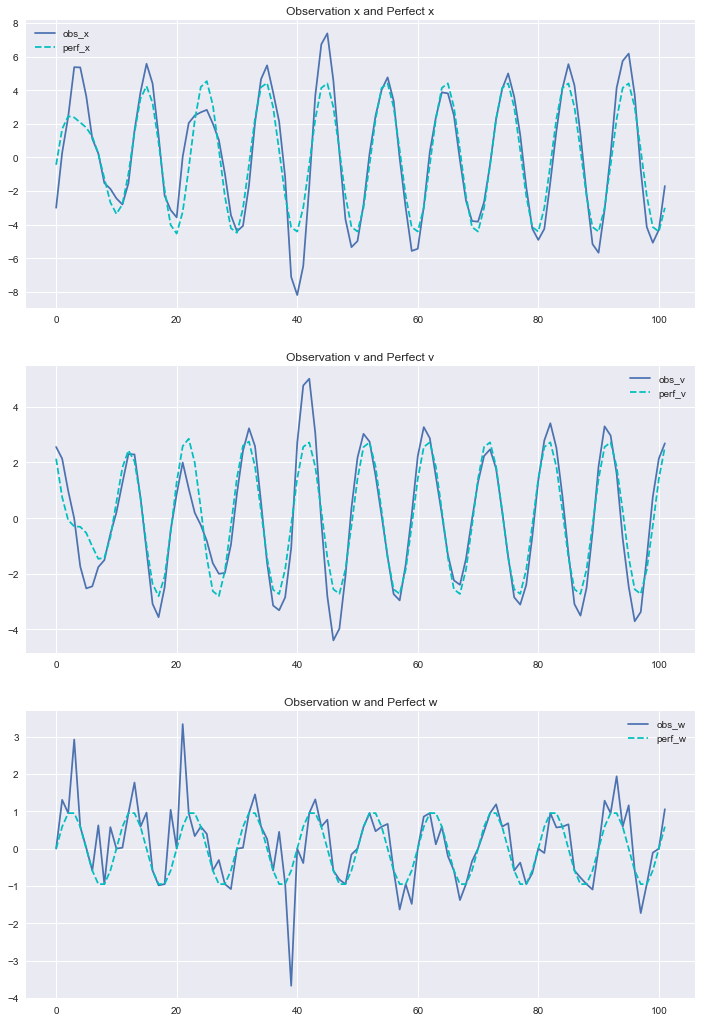

In [125]:
plt.figure(figsize = (12, 18))
plt.subplot(3, 1, 1)
plt.plot(x_obs, label = 'obs_x')
plt.plot(x_perf, linestyle = '--', color = 'c', label = 'perf_x')
plt.title("Observation x and Perfect x")
plt.legend(loc = 'best')

plt.subplot(3, 1, 2)
plt.plot(v_obs, label = 'obs_v')
plt.plot(v_perf, linestyle = '--', color = 'c', label = 'perf_v')
plt.title("Observation v and Perfect v")
plt.legend(loc = 'best')

plt.subplot(3, 1, 3)
plt.plot(w_obs, label = 'obs_w')
plt.plot(w_perf, linestyle = '--', color = 'c', label = 'perf_w')
plt.title("Observation w and Perfect w")
plt.legend(loc = 'best')
plt.show()

割と観測値にばらつきをもたせている

In [128]:
# make observation y
y  = np.array([x_obs]).T
print(y.shape)

(102, 1)


In [148]:
kf = Kalman_Filter(y, sim_initial, V0, F, G, H, Q, R, Gw)
kf.Filter()
kf.RTS_Smooth()

 smooth calculating... t=102/102

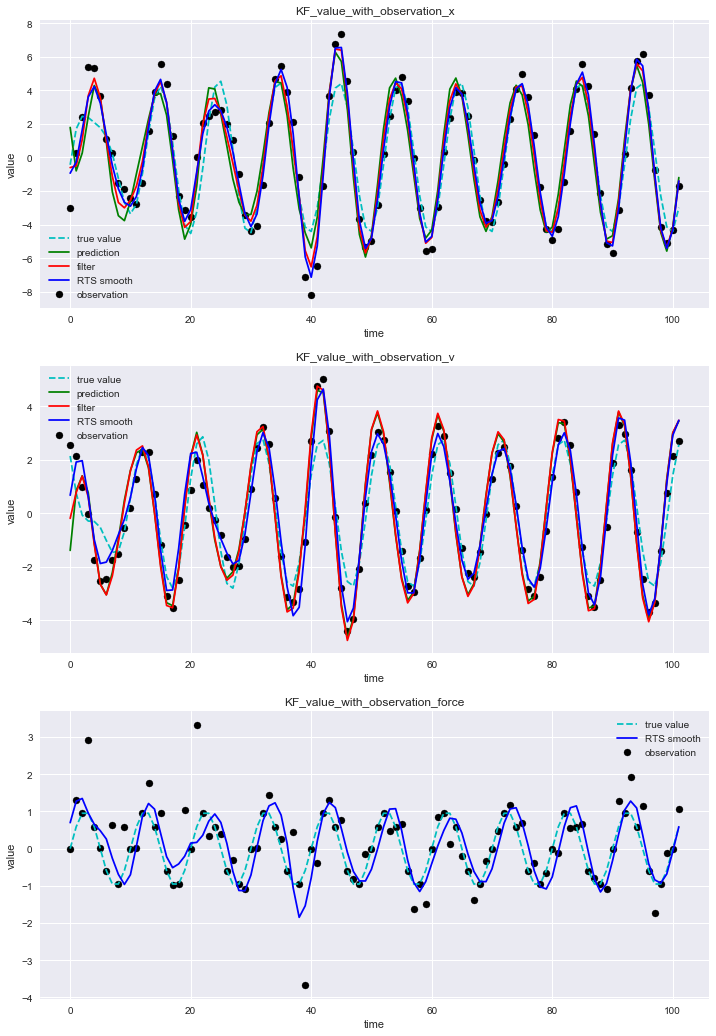

In [150]:
L = len(y)

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
plt.scatter(range(L), x_obs, color = "k", marker = 'o', label = "observation")
plt.plot(range(L), x_perf, color = 'c', linestyle = '--', label = 'true value')
plt.plot(kf.Get_Predicted_Value(0), color = 'g', label =  'prediction')
plt.plot(kf.Get_Filtered_Value(0), color = "r", label = "filter")
plt.plot(kf.Get_RTS_Smoothed_Value(0), color = 'b', label = 'RTS smooth')
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("KF_value_with_observation_x")

plt.subplot(3, 1, 2)
plt.scatter(range(L), v_obs, color = "k", marker = 'o', label = "observation")
plt.plot(range(L), v_perf, color = 'c', linestyle = '--', label = 'true value')
plt.plot(kf.Get_Predicted_Value(1), color = 'g', label = 'prediction')
plt.plot(kf.Get_Filtered_Value(1), color = "r", label = "filter")
plt.plot(kf.Get_RTS_Smoothed_Value(1), color = 'b', label = 'RTS smooth')
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("KF_value_with_observation_v")

plt.subplot(3, 1, 3)
plt.scatter(range(L), w_obs, color = "k", marker = 'o', label = "observation")
plt.plot(range(L), w_perf, color = 'c', linestyle = '--', label = 'true value')
plt.plot(w_perf + kf.Get_RTS_Smoothed_Forcing_Noise_Value(1), color = 'b', label = 'RTS smooth')
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("KF_value_with_observation_force")

plt.savefig("../plot/171209_KF_position_velocity_force.png")
plt.show()

### MSE, RMSE (結果の評価)

In [138]:
x_sim, v_sim, w_sim = make_simulation(sim_initial, m, w, k, r, dt, T, np.sqrt(sim_noise))

In [153]:
mse = np.zeros((5, 3))
mse[0, 0] = MSE(x_perf, x_sim)
mse[0, 1] = MSE(v_perf, v_sim)
mse[0, 2] = MSE(w_perf, w_sim)
mse[1, 0] = MSE(x_perf, x_obs)
mse[1, 1] = MSE(v_perf, v_obs)
mse[1, 2] = MSE(w_perf, w_obs)
mse[2, 0] = MSE(x_perf, kf.Get_Predicted_Value(0))
mse[2, 1] = MSE(v_perf, kf.Get_Predicted_Value(1))
mse[3, 0] = MSE(x_perf, kf.Get_Filtered_Value(0))
mse[3, 1] = MSE(v_perf, kf.Get_Filtered_Value(1))
mse[4, 0] = MSE(x_perf, kf.Get_RTS_Smoothed_Value(0))
mse[4, 1] = MSE(v_perf, kf.Get_RTS_Smoothed_Value(1))
mse[4, 2] = MSE(w_perf, w_perf + kf.Get_RTS_Smoothed_Forcing_Noise_Value(1))
df_mse = pd.DataFrame(mse, index = ['perfect simulation', 'observation', 'prediction', 'filter', 'RTS smooth'], columns = ['x', 'v', 'w'])
df_mse

,x,v,w
perfect simulation,1.836136,0.688785,0.328104
observation,1.683725,0.591789,0.437563
prediction,1.670310,1.013257,0.000000
filter,1.166836,0.997252,0.000000
RTS smooth,1.006116,0.598276,0.207537


In [154]:
rmse = np.sqrt(mse)
df_rmse = pd.DataFrame(rmse, index = ['perfect simulation', 'observation', 'prediction', 'filter', 'RTS smooth'], columns = ['x', 'v', 'w'])
df_rmse

,x,v,w
perfect simulation,1.355041,0.829931,0.572803
observation,1.297584,0.769279,0.661485
prediction,1.292405,1.006607,0.000000
filter,1.080202,0.998625,0.000000
RTS smooth,1.003053,0.773483,0.455563


RTS smoothing が一番誤差は小さいという妥当な結果が得られた！

今日の感想
- Filter, Prediction が時点 t　に対して配列も t 番目が対応しているのに対し，RMS smooth で時点 t に対して配列 t-1 番目が対応しているというわかりにくさからコードに割と手間取った
- RMSE を出していなかったら Smoothing おかしいなぐらいで終わってた可能性もある
- また，observation の生成の仕方も偶数時に生成するという特殊な場合だったのをよく読まずに実装したのはよろしくなかった
- 何はともあれコードが完成したので万歳